## Regression Project
---

In this regression project, we'll work with the dataset `canada_rent.csv` containing rental prices for units in across Canada in 2024 and obtained from [rentfaster.ca](https://www.rentfaster.ca/?utm_source=OOH&utm_medium=sign&utm_campaign=ca).

Our goal is to explore multiple regression models, in order to find a model that predicts the rental price most accurately.

To do this, we will:
1. Read and explore the data
2. Clean and prepare the data
3. Compare different regression models
4. Choose the best model and make predictions on provided input.

## 1. Imports + Data Loading

### 1.1 Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1.2 Load and explore data

In [2]:
df = pd.read_csv("./canada_rent.csv")
df.head()

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


### Exploratory Data Analysis

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

,rentfaster_id,latitude,longitude,price
count,25771.000000,25771.000000,25771.000000,25771.000000
mean,471913.795274,48.903370,-100.332196,2151.624142
std,120330.335865,3.603257,17.917001,972.820941
min,820.000000,40.741802,-128.661880,0.000000
25%,415749.000000,45.418785,-114.074660,1600.000000
50%,522379.000000,50.913739,-113.513905,2045.000000
75%,563397.500000,51.093585,-79.401311,2550.000000
max,572635.000000,62.459246,-52.695472,29990.000000


C:\Users\Alda\anaconda3\Anaconda_new\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


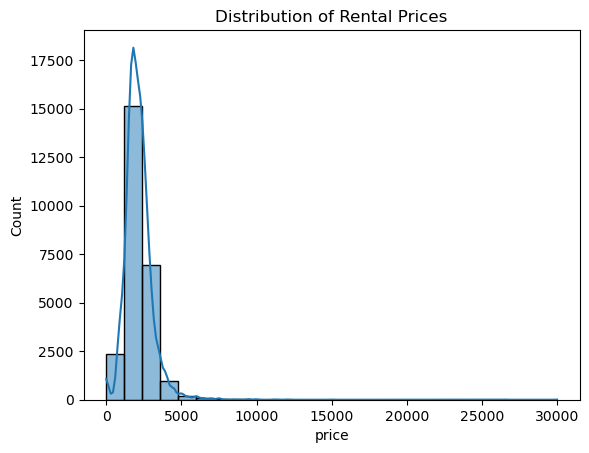

In [4]:
# We create an histogram to show the distribution of rental prices
sns.histplot(df['price'], bins=25, kde=True)
plt.title('Distribution of Rental Prices')
plt.show()

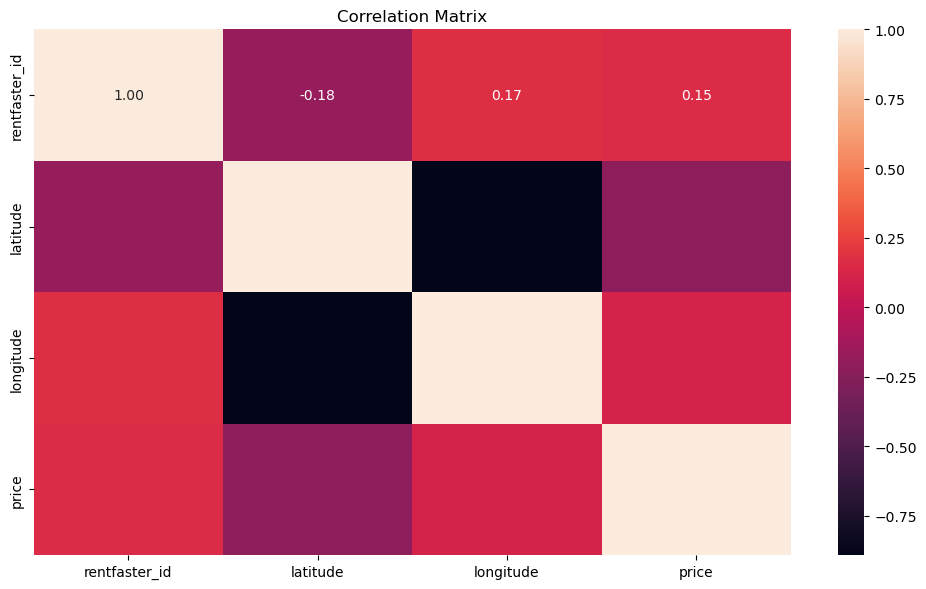

In [5]:
# Let's see the correlation of numerical variables
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Now let's plot it
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

We can see that among factors captured by the matrix, there is no significant correlations. Let's figure out if other variables can have more correlation with price.

## 2. Clean and prepare data

We can see that we have a lot of categorical columns and just few numerical ones. We'll transform necessary categorical columns into numerical format. Let's clean and prepare our data.

In [6]:
# We remove all missing values
df=df.dropna()

# We remove the link column cause it is not revelant for our analysis
df= df.drop('link',axis=1)

# We convert sq_feet column from object to float
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')
df['sq_feet']=df['sq_feet'].fillna(0)

# We convert beds and baths into float in order to have only numbers, without strings
df['beds'] = df['beds'].str.extract('(\d+)').astype(float) # Studio will be NaN
df.loc[df['beds'].isna(), 'beds'] = 0  # Assign 0 to 'Studio' (NaN values)

df['baths'] = df['baths'].replace('none', '0').astype(float)

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 19337 entries, 0 to 25770
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      19337 non-null  int64  
 1   city               19337 non-null  object 
 2   province           19337 non-null  object 
 3   address            19337 non-null  object 
 4   latitude           19337 non-null  float64
 5   longitude          19337 non-null  float64
 6   lease_term         19337 non-null  object 
 7   type               19337 non-null  object 
 8   price              19337 non-null  float64
 9   beds               19337 non-null  float64
 10  baths              19337 non-null  float64
 11  sq_feet            19337 non-null  float64
 12  furnishing         19337 non-null  object 
 13  availability_date  19337 non-null  object 
 14  smoking            19337 non-null  object 
 15  cats               19337 non-null  object 
 16  dogs               19337 no

,rentfaster_id,latitude,longitude,price,beds,baths,sq_feet
count,19337.000000,19337.000000,19337.000000,19337.000000,19337.000000,19337.000000,19337.000000
mean,460840.405492,49.161789,-101.672469,2166.144573,1.768992,1.435202,872.113147
std,125130.935253,3.531318,17.473785,893.703637,0.971488,0.666610,506.605291
min,820.000000,42.040814,-128.661880,0.000000,0.000000,0.000000,0.000000
25%,394521.000000,45.468491,-114.078523,1650.000000,1.000000,1.000000,600.000000
50%,508373.000000,50.972034,-113.532879,2067.860000,2.000000,1.000000,800.000000
75%,559539.000000,51.105808,-79.577513,2550.000000,2.000000,2.000000,1031.000000
max,572635.000000,62.459246,-52.695472,26500.000000,9.000000,7.500000,11700.000000


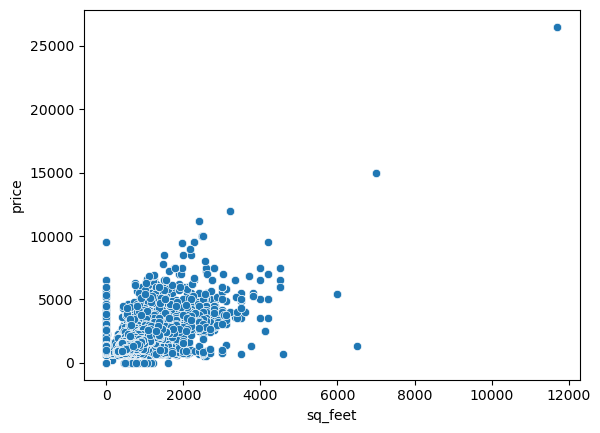

In [8]:
# Lets see relationship between price and sq_feet now that we converted it from object to numerical column

# Scatter plot for price and sq_feet
sns.scatterplot(x='sq_feet', y='price', data=df)
plt.show()

In [9]:
# We transform unique element in smoking and furnishing into columns in order to use them later
new_df=pd.get_dummies(df, columns=['smoking','furnishing'], prefix='',prefix_sep='')

# We select only columns we will use for our regression
df2=new_df[['beds','baths','sq_feet','price','cats','dogs','Non-Smoking','Furnished']]

# In order to have only numerical columns, we convert all categorical columns in our df
bool_columns = ['cats', 'dogs','Non-Smoking','Furnished']
for col in bool_columns:
    df2[col] = df2[col].astype(int)

df2

C:\Users\Alda\AppData\Local\Temp\ipykernel_16492\4009756124.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype(int)
C:\Users\Alda\AppData\Local\Temp\ipykernel_16492\4009756124.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype(int)
C:\Users\Alda\AppData\Local\Temp\ipykernel_16492\4009756124.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,beds,baths,sq_feet,price,cats,dogs,Non-Smoking,Furnished
0,2.0,2.5,1403.0,2495.0,1,1,1,0
1,3.0,2.5,1496.0,2695.0,1,1,1,0
2,2.0,2.5,1180.0,2295.0,1,1,1,0
3,2.0,2.5,1403.0,2095.0,1,1,1,0
4,2.0,2.5,1403.0,2495.0,1,1,1,0
...,...,...,...,...,...,...,...,...
25766,0.0,1.0,400.0,920.0,1,1,1,0
25767,3.0,1.0,810.0,1450.0,1,1,1,0
25768,1.0,1.0,520.0,1125.0,1,1,1,0
25769,0.0,1.0,400.0,920.0,1,1,1,0


We can create a scatterplot of some feature X against the target variable y (price) to look for linearity.

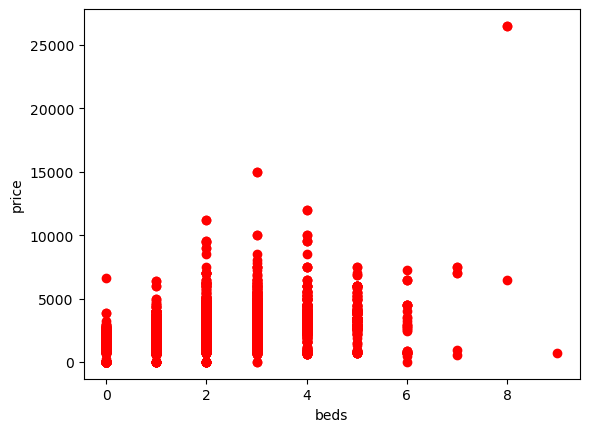

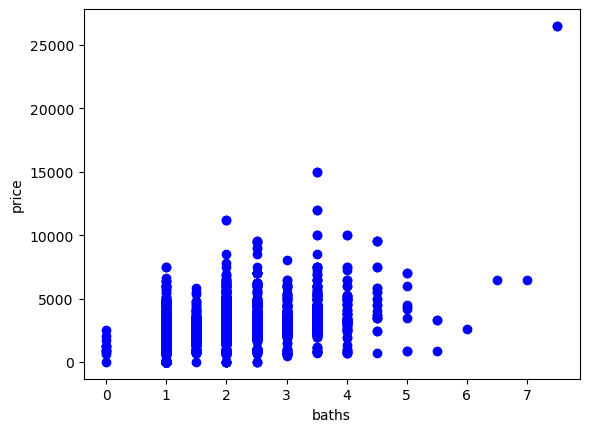

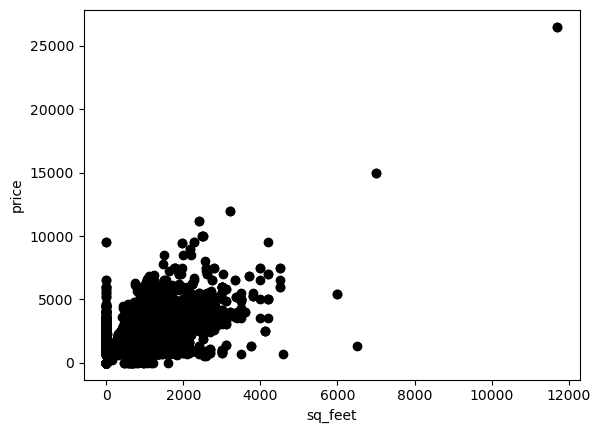

In [10]:
plt.scatter(df['beds'], df['price'], color='red')
plt.xlabel("beds")
plt.ylabel("price")
plt.show()

plt.scatter(df['baths'], df['price'], color='blue')
plt.xlabel("baths")
plt.ylabel("price")
plt.show()

plt.scatter(df['sq_feet'], df['price'], color='black')
plt.xlabel("sq_feet")
plt.ylabel("price")
plt.show()

The above scatterplots demonstrate some linear relationship betwen the independent variables X and the target variable y.

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19337 entries, 0 to 25770
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   beds         19337 non-null  float64
 1   baths        19337 non-null  float64
 2   sq_feet      19337 non-null  float64
 3   price        19337 non-null  float64
 4   cats         19337 non-null  int32  
 5   dogs         19337 non-null  int32  
 6   Non-Smoking  19337 non-null  int32  
 7   Furnished    19337 non-null  int32  
dtypes: float64(4), int32(4)
memory usage: 1.0 MB


As we can see, df2 has only numerical columns, which is good for our regression models. We selected only revelant columns for our analysis, such as 'price' column which will be our target variable, but also 'beds','baths', 'sq_feet', 'cats','dogs','Non-smoking' and 'Furnished'which have a big impact on the price and which will be our  independent features.

## 3. Regression models

We will now compare 3 different regression models in order to see which one give better results. To do this, we'll compare Linear regression, ridgeCV and Lasso models.

### 3.1. Linear Regression

Let's start with linear regression. We'll separate independant features X and target variable y, split data into train and test where we'll use 10% for testing and 90% for training. Then we'll create and train our first model.

In [12]:
# Separate features and target variable
X = df2.drop('price', axis=1)
y = df2['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

# scale data
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# we create instance of model
slr_model = LinearRegression()
slr_model.fit(X_scaled_train, y_train)

LinearRegression()

Now, we can test our model by obtaining metrics MAE, MSE, RMSE and R2 scores.

In [13]:
#Obtain y hat (y_pred) values
y_pred = slr_model.predict(X_scaled_test)

#Now we can obtain the MAE, MSE, RMSE and R2 scores
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

print('Linear Regression Metrics: MAE =', MAE,',  MSE =', MSE,', RMSE =',RMSE, ',  R2 =', R2)

Linear Regression Metrics: MAE = 486.5628097122212 ,  MSE = 785420.1618374634 , RMSE = 886.2393366565622 ,  R2 = 0.42558131649733244


We can also interpret coefficients

In [14]:
coeff_df = pd.DataFrame(slr_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
beds,100.391787
baths,276.739152
sq_feet,191.481596
cats,-7.517526
dogs,125.835529
Non-Smoking,-7.692905
Furnished,67.432859


We can see that adding one bedroom is associated with an increase of 103.33 in price, assuming all other independant features remain constant.
Likewise, adding a bathroom increases the price by 416.30 assuming all other features remain constant. 
Allowing dogs is associated with an increase of $262.21 in price, assuming all other independant features remain constant. etc.

### 3.2. Ridge Model

We'll first apply polynomial features, and then we will explore how regularization can be used to simplify the resulting models. We'll still work with df2 where y is price and the other columns are X. We'll create PolynomialFeatures and fit_transform X features. And once again we'll train-test plit but this time we will use poly_feature (X_poly) instead of X.

In [15]:
#Create polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

#Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_poly, y, test_size = 0.15, random_state = 1)

Now we can apply and evaluate Ridge model

In [16]:
# scale data
X_scaled_train2 = scaler.fit_transform(X_train2)
X_scaled_test2 = scaler.transform(X_test2)


# Create instance of model
ridge_model = Ridge(alpha=13)

# Fit the model
ridge_model.fit(X_scaled_train2, y_train2)

Ridge(alpha=13)

In [17]:
# We predict on test and get metrics
y_pred2 = ridge_model.predict(X_scaled_test2)

MAE_r = mean_absolute_error(y_test2, y_pred2)
MSE_r = mean_squared_error(y_test2, y_pred2)
RMSE_r = np.sqrt(MSE_r)
R2_r = r2_score(y_test2, y_pred2)


print('Rigde Metrics: MAE =', MAE_r, 'MSE =', MSE_r, 'RMSE=',RMSE_r, 'R2 =', R2_r)

Rigde Metrics: MAE = 467.81836179687923 MSE = 475707.6893391302 RMSE= 689.7156583253204 R2 = 0.5883982518575712


In [18]:
# model coefficients
ridge_model.coef_

array([ 256.20311636,  -26.16842989,  333.25729189,  -78.8881852 ,
         71.45448958,  -18.79247257,   -7.34559999, -150.92181456,
        192.48618093, -400.12947807,  -99.22000321,   48.26974025,
         70.13988759,  -32.97522472, -162.40489297,  125.49610516,
         87.49189764,   -9.44449278,  264.65503919,  137.40218481,
        218.88548445,   67.37997965,   41.70557004, -198.09823189,
        -44.97927694,  -78.8881852 ,   94.98596893,   81.99489327,
         13.00594745,   71.45448958, -185.18116193,   89.70116556,
        -18.79247257,  -33.69373434,   -7.34559999])

### 3.3. LassoCv

Now, we will create a lassoCv model and obtain error metrics in order to compare them with those obtained with the 2 previous models and see which one performs better.

In [19]:
from sklearn.pipeline import Pipeline
# Separate features and target variable for our LassoCv Model
X_lCv = df2.drop('price', axis=1)
y_lCv = df2['price']

# Train_test split 
X_lCv_train, X_lCv_test, y_lCv_train, y_lCv_test = train_test_split(X_lCv, y_lCv, test_size=0.15, random_state=42)


# Create lassoCv model
lassocv_model = LassoCV(eps=0.01, n_alphas=200, cv=5) 

# Initialize the StandardScaler
scaler = StandardScaler()

# Pipeline application
to_Pline = [('scaler', scaler), ('lassocv_model', lassocv_model)]
lasso = Pipeline(to_Pline)

# Fit the model
lasso.fit(X_lCv_train, y_lCv_train)

# Pred on test
y_lCv_pred = lasso.predict(X_lCv_test)

# Obtain metrics
MAE_cv = mean_absolute_error(y_lCv_test, y_lCv_pred)
MSE_cv = mean_squared_error(y_lCv_test, y_lCv_pred)
RMSE_cv = np.sqrt(MSE_cv)
R2_cv = r2_score(y_lCv_test, y_lCv_pred)

print('LassoCv Metrics: MAE =', MAE_cv,',  MSE =', MSE_cv,', RMSE =',RMSE_cv, ',  R2 =', R2_cv)

LassoCv Metrics: MAE = 465.2874753267636 ,  MSE = 464823.41118269047 , RMSE = 681.7795913509663 ,  R2 = 0.32077149227325863


We can see that lassoCv model performs better according to the error metrics we obtained which are smaller than those of ridge model.

## 4- Predictions

Now that we compared different models and we saw that LassoCv performs better, we will use this model to make predictions on provided input.

In [20]:
# We use LassoCv model to predict the above sales

new_data = pd.DataFrame({'beds': [3], 'baths': [1.5], 'sq_feet': [1000], 'cats': [True],'dogs': [False],
                          'Non-Smoking': [True],'Furnished': [True] })

# Scale the new data using the same scaler used for training
pred_data_scaled = scaler.transform(new_data)

# Predict sales units
predicted_price = lasso.predict(pred_data_scaled)

print('The predicted price according to your choice is:', predicted_price[0])

The predicted price according to your choice is: 1378.5351292887322


C:\Users\Alda\anaconda3\Anaconda_new\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
